In [12]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
# import statsmodels.api as sm
from causalimpact import CausalImpact
import warnings
warnings.filterwarnings('ignore')

/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/_distutils_hack/__init__.py:11: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/_distutils_hack/__init__.py:26: UserWarning:

Setuptools is replacing distutils.

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## (2) John Snowデータの読み込み
Data from Table.12 in Snow(1855)  
http://www.ph.ucla.edu/epi/snow/table12a.html  

In [ ]:
## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1849 = [283,157,192,249,259,226,352,97,111,8,235,92]
### Lambeth Company & Southwark and Vauxhall Company
lsv1849 = [256,267,312,257,318,446,143,193,243,215,544,187,153,81,113,176]

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1854 = [371, 161, 148, 362, 244, 237, 282, 59, 171, 9, 240, 174]
### Lambeth Company & Southwark and Vauxhall Company
lsv1854 = [113,174,270,93,210,388,92,58,117,49,193,303,142,48,165,132]

## コレラの死者数を会社ごとにまとめる
sv_death = sv1849 + sv1854
lsv_death = lsv1849 + lsv1854

## どのデータがどのエリアのものか
sv_area = [f'sv_{i}' for i in range(1, len(sv1849)+1)] + [f'sv_{i}' for i in range(1, len(sv1854)+1)]
lsv_area = [f'lsv_{i}' for i in range(1, len(lsv1849)+1)] + [f'lsv_{i}' for i in range(1, len(lsv1854)+1)]

## どのデータがどの年のものか
sv_year = [1849 for i in range(0, len(sv1849))] + [1854 for i in range(0, len(sv1854))]
lsv_year = [1849 for i in range(0, len(lsv1849))] + [1854 for i in range(0, len(lsv1854))]

## Southwark & Vauxhallのデータフレームを作成
sv = pd.DataFrame({
    'area': sv_area,
    'year': sv_year,
    'death': sv_death,
    'LSV': 0,
    'company': 'Southwark and Vauxhall'
})

## Lambeth & Southwark and Vauxhallのデータフレームを作成
lsv = pd.DataFrame({
    'area': lsv_area,
    'year': lsv_year,
    'death': lsv_death,
    'LSV': 1,
    'company': 'Lambeth & Southwark and Vauxhall'
})

## 地域・年別のデータセットの作成
JS_df = pd.concat([sv, lsv], ignore_index=True)

## 会社別のデータセットを作成
JS_sum = JS_df.groupby(['company', 'LSV', 'year'], as_index=False).death.sum()

## (3) 集計と可視化による分析


In [ ]:
## 集計による推定
JS_grp_summary = JS_sum.pivot_table(
    values='death', index=['company', 'LSV'], columns=['year'], aggfunc='sum').add_prefix('year_').reset_index()
JS_grp_summary['gap'] = JS_grp_summary.year_1854 - JS_grp_summary.year_1849
JS_grp_summary['gap_rate'] = JS_grp_summary.year_1854 / JS_grp_summary.year_1849 - 1
JS_grp_summary

year,company,LSV,year_1849,year_1854,gap_rate
0,Lambeth & Southwark and Vauxhall,1,3904,2547,-0.347592
1,Southwark and Vauxhall,0,2261,2458,0.087130


In [ ]:
## 集計による推定(log)
JS_grp_summary_ln = JS_sum.pivot_table(
    values='death', index=['company', 'LSV'], columns=['year'], aggfunc='sum').add_prefix('year_').reset_index()
JS_grp_summary_ln.year_1849 = np.log(JS_grp_summary_ln.year_1849)
JS_grp_summary_ln.year_1854 = np.log(JS_grp_summary_ln.year_1854)
JS_grp_summary_ln['gap'] = JS_grp_summary_ln.year_1854 - JS_grp_summary_ln.year_1849
JS_grp_summary_ln['gap_rate'] = JS_grp_summary_ln.year_1854 / JS_grp_summary_ln.year_1849 - 1
JS_grp_summary_ln

year,company,LSV,year_1849,year_1854,gap,gap_rate
0,Lambeth & Southwark and Vauxhall,1,8.269757,7.842671,-0.427085,-0.051644
1,Southwark and Vauxhall,0,7.723562,7.807103,0.083541,0.010816


## plotly expressによる可視化

In [ ]:
fig = px.scatter(JS_sum, x='year', y='death', color='company', trendline="ols", symbol='company', title='4.2 コレラによる死者数')
# 補助線を追加していく
fig.add_trace(go.Scatter(
    x=[1849, 1854],
    y=[3904, 3904 + 197],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    name=''
))
fig.add_trace(go.Scatter(
    x=[1849, 1854],
    y=[3904, 3904],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    name=''
))
fig.add_trace(go.Scatter(
    x=[1849, 1854],
    y=[2261, 2261],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    name=''
))
fig.add_trace(go.Scatter(
    x=[1854.2, 1854.2],
    y=[2261, 2458],
    mode="lines+markers",
    line=dict(color='gray', width=1),
    name='',
))
fig.add_trace(go.Scatter(
    x=[1854.2],
    y=[2350],
    mode="text",
    name='',
    text='(1)',
    textposition='middle right'
))
fig.add_trace(go.Scatter(
    x=[1854.2, 1854.2],
    y=[3904, 3904+197],
    mode="lines+markers",
    line=dict(color='gray', width=1),
    name='',
))
fig.add_trace(go.Scatter(
    x=[1854.2],
    y=[3904+99],
    mode="text",
    name='',
    text='(2)',
    textposition='middle right'
))
fig.add_trace(go.Scatter(
    x=[1854.2, 1854.2],
    y=[2547, 3904],
    mode="lines+markers",
    line=dict(color='gray', width=1),
    name=''
))
fig.add_trace(go.Scatter(
    x=[1854.2],
    y=[3200],
    mode="text",
    name='',
    text='(3)',
    textposition='middle right'
))

In [ ]:
fig.write_html('../images/ch4_plot1.html', auto_open=False)

## (4) 回帰分析を用いたDID

In [ ]:
## Difference in Difference
JS_did = JS_sum.copy()
JS_did['D1854'] = JS_did.year.apply(lambda x: 1 if x == 1854 else 0)
JS_did['D1854_LSV'] = JS_did.D1854 * JS_did.LSV

y = JS_did.death
X = JS_did[['LSV', 'D1854', 'D1854_LSV']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,2261.0000,inf,0,nan,nan,nan
LSV,1643.0000,inf,0,nan,nan,nan
D1854,197.0000,inf,0,nan,nan,nan
D1854_LSV,-1554.0000,inf,-0,nan,nan,nan


In [ ]:
## Difference in Difference(log)
JS_did_log = JS_sum.copy()
JS_did_log['D1854'] = JS_did_log.year.apply(lambda x: 1 if x == 1854 else 0)
JS_did_log['D1854_LSV'] = JS_did_log.D1854 * JS_did_log.LSV

y = np.log(JS_did_log.death)
X = JS_did_log[['LSV', 'D1854', 'D1854_LSV']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,7.7236,inf,0,nan,nan,nan
LSV,0.5462,inf,0,nan,nan,nan
D1854,0.0835,inf,0,nan,nan,nan
D1854_LSV,-0.5106,inf,-0,nan,nan,nan


In [ ]:
## Difference in Difference(エリア単位)
JS_did_area = JS_df.copy()
JS_did_area['D1854'] = JS_did_area.year.apply(lambda x: 1 if x == 1854 else 0)
JS_did_area['D1854_LSV'] = JS_did_area.D1854 * JS_did_area.LSV

y = JS_did_area.death
X = pd.get_dummies(JS_did_area[['LSV', 'area', 'D1854', 'D1854_LSV']], columns=['area'], drop_first=True, dtype=float)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,177.7076,15.710,11.312,0.000,145.415,210.000
LSV,49.1987,44.773,1.099,0.282,-42.833,141.230
D1854,16.4167,25.365,0.647,0.523,-35.721,68.555
D1854_LSV,-101.2292,33.554,-3.017,0.006,-170.201,-32.257


In [ ]:
## Difference in Difference(州単位、log)
JS_did_area_log = JS_df.copy()
JS_did_area_log['D1854'] = JS_did_area_log.year.apply(lambda x: 1 if x == 1854 else 0)
JS_did_area_log['D1854_LSV'] = JS_did_area_log.D1854 * JS_did_area_log.LSV

y = np.log(JS_did_area_log.death)
X = pd.get_dummies(JS_did_area_log[['LSV', 'area', 'D1854', 'D1854_LSV']], columns=['area'], drop_first=True, dtype=float)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.6461,0.082,56.393,0.000,4.477,4.815
LSV,0.7363,0.235,3.136,0.004,0.254,1.219
D1854,0.0739,0.133,0.556,0.583,-0.200,0.347
D1854_LSV,-0.5661,0.176,-3.217,0.003,-0.928,-0.204


## (7) Proposition99の分析：集計による分析

### データの用意
Rパッケージのデータセットをrpy2経由で取得するか、元データをローカルに保存しておくかの2通り記載する。

### 1. rpy2を経由してRパッケージEcdatから取得する
(事前にRにEcdatを下記のようにしてインストールする)
```
sudo R
install.packages('Ecdat')
```

In [ ]:
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
importr('Ecdat')
importr('tidyverse')
### Common Trend Assumptionの為に分析から特定の州を外す
### タバコの税金が1988年以降50セント以上上がった州のリスト
### Alaska, Hawaii, Maryland, Michigan, New Jersey, New York, Washington
r('skip_state <- c(3,9,10,22,21,23,31,33,48)')
### Cigarデータセットの読み込み
### skip_stateに含まれる州のデータを削除
cigar = r('''Cigar <- Cigar %>%
  filter(!state %in% skip_state,
         year >= 70) %>%
  mutate(area = if_else(state == 5, "CA", "Rest of US"))''')

### 2. 元データをローカルに保存して読み込む
EcdatのCRANのドキュメントを確認する(https://cran.r-project.org/web/packages/Ecdat/Ecdat.pdf )と、  
Cigarデータセットは (https://www.wiley.com/legacy/wileychi/baltagi/ )が元であることが分かる。  
いくつかデータセットがあるが、Cigarにあたるのは右記 https://www.wiley.com/legacy/wileychi/baltagi/supp/Cigar.txt  
URLから直接pd.read_csvや、requests.getしてもうまくいかない（おそらく弾いてると思われる）ので、テキストをコピペして  
ローカルに保存しておく。(下記の場合は `../data/cigar.txt`に保存している)  
※1行目および最終行に空行があるので事前に消しておく

In [13]:
cigar = pd.read_csv(
    './cigar.txt',
    header=None, 
    sep='\s',
    names=['state', 'year', 'price', 'pop', 'pop16', 'cpi', 'ndi', 'sales','pimin']
)
skip_state = [3,9,10,22,21,23,31,33,48]
cigar = cigar[(~cigar['state'].isin(skip_state)) & (cigar['year'] >= 70)].reset_index(drop=True)
cigar['area'] = cigar['state'].apply(lambda x: 'CA' if x==5 else 'Rest of US')

## 前後比較による分析

In [5]:
cigar_did = cigar.copy()
cigar_did['period'] = cigar_did.year.apply(lambda x: 'after' if x > 87 else 'before')
cigar_did['state'] = cigar_did.state.apply(lambda x: 'CA' if x==5 else 'Rest of US')
cigar_did['sales_pop16'] = cigar_did['sales'] * cigar_did['pop16']
summarised = cigar_did.groupby(['period', 'state'], as_index=False)['pop16', 'sales_pop16'].mean().sort_values('period', ascending=False)
summarised['sales'] = summarised.sales_pop16 / summarised.pop16

/var/folders/25/9b_gpl490w9ffmj63bfx0z2r0000gn/T/ipykernel_46803/69998381.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summarised = cigar_did.groupby(['period', 'state'], as_index=False)['pop16', 'sales_pop16'].mean().sort_values('period', ascending=False)


In [6]:
summarised

,period,state,pop16,sales_pop16,sales
2,before,CA,17674.250000,2.061836e+06,116.657645
3,before,Rest of US,2605.420216,3.304769e+05,126.842072
0,after,CA,22355.320000,1.724154e+06,77.124997
1,after,Rest of US,2948.603889,3.151694e+05,106.887669


In [7]:
fig = px.scatter(summarised, x='period', y='sales', color='state', symbol='state', title='4.5 タバコの売上の前後比較')
fig.add_trace(go.Scatter(
    x=['before', 'after'],
    y=[126.842072, 106.887669],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    name=''
))
fig.add_trace(go.Scatter(
    x=['before', 'after'],
    y=[116.657645, 77.124997],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    name=''
))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
fig.write_html('../images/ch4_plot2.html', auto_open=False)

## タバコの売上のトレンドを示すプロット

In [ ]:
sales_trend = cigar_did.groupby(['year', 'state'], as_index=False)['pop16', 'sales_pop16'].mean()
sales_trend['sales'] = sales_trend.sales_pop16 / sales_trend.pop16

In [ ]:
fig = px.line(sales_trend, x='year', y='sales', color='state', title='4.6 売上のトレンドの確認')
fig.show()

In [ ]:
fig.write_html('../images/ch4_plot3.html', auto_open=False)

## (8) DIDのためのデータを準備

In [ ]:
cigar['post'] = cigar.year.apply(lambda x: 1 if x > 87 else 0)
cigar['ca'] = cigar.state.apply(lambda x: 1 if x == 5 else 0)
cigar['sales_pop16'] = cigar['sales'] * cigar['pop16']

In [ ]:
cigar_did_sum = cigar.groupby(['post', 'year', 'ca'], as_index=False)['pop16', 'sales_pop16'].mean()
cigar_did_sum['sales'] = cigar_did_sum.sales_pop16 / cigar_did_sum.pop16
cigar_did_sum['ca_post'] = cigar_did_sum.ca * cigar_did_sum.post

## カリフォルニア州とその他の州という州ごとでのデータ
cigar_did_data = cigar.groupby(['post', 'year', 'state'], as_index=False)['pop16', 'sales_pop16'].mean()
cigar_did_data['sales'] = cigar_did_data.sales_pop16 / cigar_did_data.pop16

## (9) カリフォルニア州とその他というグループでの分析

In [ ]:
## 2グループでのデータでの分析
y = cigar_did_sum.sales
X = pd.get_dummies(cigar_did_sum[['ca', 'post', 'ca_post', 'year']], columns=['year'], drop_first=True)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,123.5615,4.519,27.340,0.000,114.163,132.960
ca,-9.0898,2.074,-4.384,0.000,-13.402,-4.777
post,-13.8569,4.423,-3.133,0.005,-23.054,-4.660
ca_post,-20.5435,4.447,-4.619,0.000,-29.792,-11.295


In [ ]:
## 2グループでのデータでの分析(log)
y = np.log(cigar_did_sum.sales)
X = pd.get_dummies(cigar_did_sum[['ca', 'post', 'ca_post', 'year']], columns=['year'], drop_first=True)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.8171,0.042,114.363,0.000,4.729,4.905
ca,-0.0767,0.019,-3.969,0.001,-0.117,-0.037
post,-0.1213,0.041,-2.944,0.008,-0.207,-0.036
ca_post,-0.2530,0.041,-6.105,0.000,-0.339,-0.167


(10) 州ごとのデータでの分析については、書籍に記載がなくよくわからないので飛ばします

## (11) CausalImpactを利用した分析
tfcausalimpact: https://github.com/WillianFuks/tfcausalimpact

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18149D-01    |proj g|=  1.08528D+00
  ys=-5.568E-01  -gs= 1.057E+00 BFGS update SKIPPED

At iterate    5    f= -1.15190D+00    |proj g|=  7.30751D+00

At iterate   10    f= -1.99048D+00    |proj g|=  5.11931D+00

At iterate   15    f= -2.51035D+00    |proj g|=  1.01409D+01

At iterate   20    f= -2.99120D+00    |proj g|=  3.00652D+01

At iterate   25    f= -3.90689D+00    |proj g|=  6.35239D+01

At iterate   30    f= -4.13520D+00    |proj g|=  8.60805D+01

At iterate   35    f= -4.44483D+00    |proj g|=  1.51813D+02

At iterate   40    f= -4.67388D+00    |proj g|=  1.28394D+02

At iterate   45    f= -5.09685D+00    |proj g|=  3.29499D+02

At iterate   50    f= -5.42378D+00    |proj g|=  2.06138D+02

At iterate   55    f= -5.61645D+00    |proj g|=  2.12594D+02

At iterate   60    f= -5.94755D+00  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


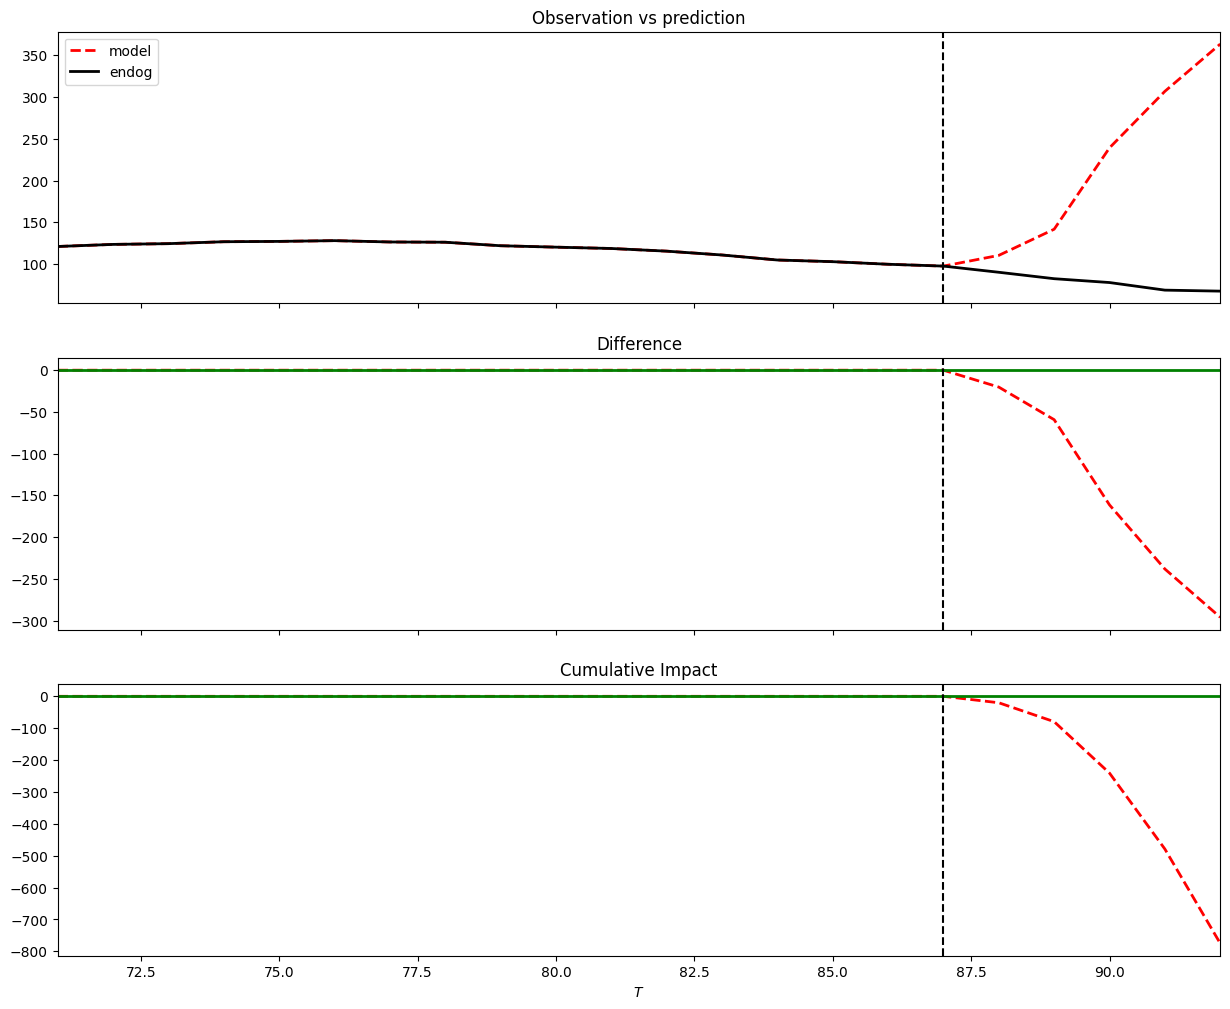

In [16]:
y = cigar[cigar.state == 5][['year', 'sales']].set_index('year')
y.columns = ['y']
X = pd.pivot_table(cigar[cigar.state != 5][['year', 'state', 'sales']], values='sales', index='year', columns='state').add_prefix('X_')
data = pd.concat([y, X], axis=1)

pre_period = [70, 87]
post_period = [88, 92]
ci = CausalImpact(data, pre_period, post_period, model_args={'fit_method': 'hmc'})
ci.run()
ci.plot()

In [ ]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         89.61 (7.89)       448.05 (39.45)
95% CI                    [71.48, 102.41]    [357.42, 512.04]

Absolute effect (s.d.)    -12.31 (7.89)      -61.55 (39.45)
95% CI                    [-25.11, 5.82]     [-125.54, 29.08]

Relative effect (s.d.)    -13.74% (8.8%)     -13.74% (8.8%)
95% CI                    [-28.02%, 6.49%]   [-28.02%, 6.49%]

Posterior tail-area probability p: 0.07
Posterior prob. of a causal effect: 93.01%

For more details run the command: print(impact.summary('report'))
